<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/Test_gp_lvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

Populating the interactive namespace from numpy and matplotlib


In [0]:
sess=tf.InteractiveSession()

In [0]:
# load the MNIST data set
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
# print(x_train.size) -> 47040000
# print(x_train[0].shape) -> (28,28)

# we will use first 1000
N = 1000
# a[:N,...] first N element over all dimentions
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

# the observations are the flattened images ( 28x28 -> 784x1)
# We have to mentione that we will have an independent GP for each input variable
# in other words : we have 784 GP
# this is because each pixel will be treated as an independent GP 
# conditioned on the latent input
# input : latent vector -> output : 784 pixels
# transpose to change th shape from [1000,784] to [784,1000] -> 1000 index points
obs=small_x_train.reshape(N,-1).transpose()

# latent embeddings of the data
# N , 2D index points
# here we use random initialization
init=np.random.normal(size=(N,2))
lat_ind_pts=tf.get_variable(name="latent_index_points",dtype=tf.float64,initializer=init)
# we can try with PCA initialization


In [0]:
# generate training variable
# a - amplitude
# ls - length scale
# obs_nv - observation noise variance
# these variables will be optimized during the training

# finfo : Machine limits for floating point types
# tiny : The smallest positive usable numbe
# softplus: a smooth approximation of a rectifier 
# rectifier(x) = max(0,x)
# softplus(x) = log(1+exp(x))
tiny=np.finfo(np.float64).tiny

a_variable=tf.Variable(initial_value=1,name="amplitude",dtype=np.float64)
a=(tiny + tf.nn.softplus(a_variable))

ls_variable=tf.Variable(initial_value=1,name="length_scale",dtype=np.float64)
ls=(tiny + tf.nn.softplus(ls_variable))

obs_nv_variable=tf.Variable(initial_value=1,name="observation_noise_variance",dtype=np.float64)
obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))

In [0]:
# use Exponentiated quadratic kernel
# or could be called squared exponential, Gaussian, or radial basis function
# k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
kernel = tfk.ExponentiatedQuadratic( a, ls )

# creat GP prior distribtion
gp=tfd.GaussianProcess(kernel=kernel, index_points=lat_ind_pts, observation_noise_variance=obs_nv)

# log likelihood for obseration, the goal is to maximize it
log_likelihood=gp.log_prob(obs)

# define the loss
# reduced sum because the observation is IID (Independent and identically distributed random variables)
loss=-tf.reduce_sum(log_likelihood)

# define optimizer
optimizer=tf.train.AdamOptimizer(learning_rate=0.1)
train_op=optimizer.minimize(loss)

In [0]:
# so we have a 2D latent input space
# we will draw samples from it
# the samples will be on grid in the latent space
sample_grid_points=10
# 10 points evenly spaced between -4 and 4 
grid=np.linspace(-4,4,sample_grid_points).astype(np.float64)
# The purpose of meshgrid is to create a rectangular grid out of 
# an array of x values and an array of y values.
# here a 10x10 square grid
grid=np.stack(np.meshgrid(grid,grid),axis=-1)

# Speed up the computation by vectorization:
# We will add more dimensions to the batch; we concatenated:
# 1. batch shape : [sample_grid_points, sample_grid_points, 1]
# 2. number of exaples : [1]
# 3. number of latent input dimensions : [2]
# the results will be samples of shape [10,10,784,1]
# we can use np.squeeze to drop out 1 (number of examples)
# np.squeeze : drop out a dimension from an array (tensor) 
# ex.: (2,1) -> (2,)
grid=grid.reshape(sample_grid_points,sample_grid_points,1,1,2)

# create GP regression model wich representsthe posterior;
# the input is the grid (different latent index points)
# the output is a batch of 784 independent posteriors (for each pixel)
gpr=tfd.GaussianProcessRegressionModel(kernel=kernel, index_points=grid,
                                      observation_index_points=lat_ind_pts, observations=obs)

# create a sample operation in the TF graph
samples=gpr.sample()

In [0]:
num_iters=100
# optimize the model parameters
sess.run(tf.global_variables_initializer())
losses=[]
# latent variable after training
latent_index_points=[]

for i in range(num_iters):
  _,l,lip=sess.run([train_op,loss,lat_ind_pts])
  losses.append(l)
  latent_index_points.append(lip)

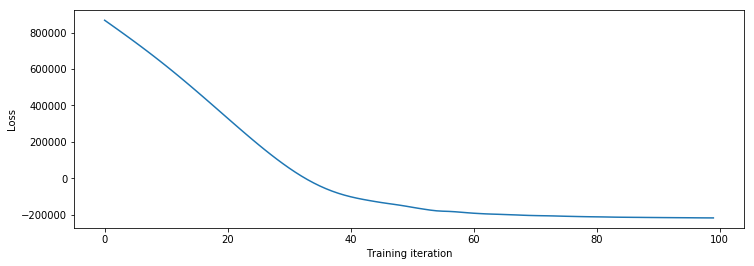

In [25]:
# plot the loss function (likelihood)
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel("Training iteration")
plt.ylabel("Loss")
plt.show()

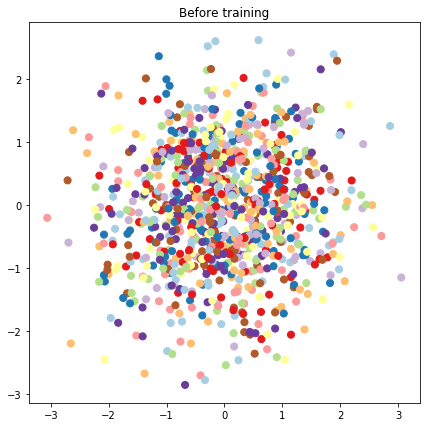

In [28]:
# plot the latent locations before training
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.scatter(x=init[:, 0], y=init[:, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

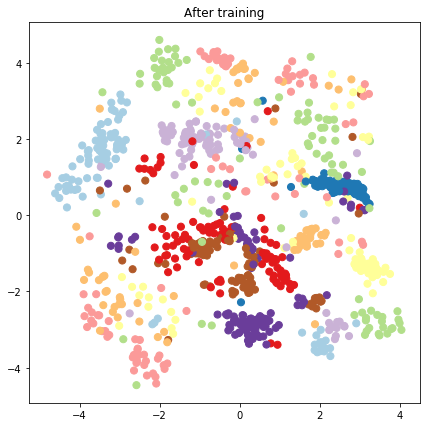

In [39]:
# plot the latent locations after training
# print(latent_index_points[0].shape) (1000,2)
# the results in the last element in the list (at the end of training)
plt.figure(figsize=(7, 7))
plt.title("After training")
plt.scatter(x=latent_index_points[-1][:,0], y=latent_index_points[-1][:,1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

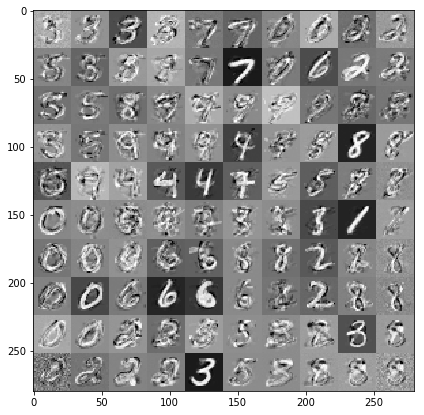

In [43]:
# draw samples (100 point on a 2D grid in the latent space)
samples_res=sess.run(samples)

# show the samples 
# here we squeezing odd 1-shapes 
samples_ = np.squeeze(samples_res)
# normalization
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
# reshape the image (opposite of flatten) 784 -> 28x28
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)

# TODO : why [0,2,1,3]
# change the axis by the array [0,2,1,3]
samples_ = samples_.transpose([0, 2, 1, 3])
# put them aal together
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()